# Convolutional Variational Autoencoder - MNIST

Slightly modified from variational_autoencoder_deconv.py in the Keras examples folder:

**https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py**

In [1]:
WEIGHTS_FILEPATH = 'mnist_vae.hdf5'
MODEL_ARCH_FILEPATH = 'mnist_vae.json'

In [2]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [5]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 200
original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 0.01

x = Input(batch_shape=(batch_size,) + original_img_size)
conv_1 = Conv2D(img_chns, kernel_size=(2,2), padding='same', activation='relu')(x)
conv_2 = Conv2D(filters, kernel_size=(2,2), strides=(2,2), padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters, kernel_size=num_conv, strides=(1,1), padding='same', activation='relu')(conv_2)
conv_4 = Conv2D(filters, kernel_size=num_conv, strides=(1,1), padding='same', activation='relu')(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

decoder_reshape = Reshape((14, 14, filters))
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size=num_conv, strides=(1,1),
                                   padding='same', activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters, kernel_size=num_conv, strides=(1,1),
                                   padding='same', activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters, kernel_size=(2,2), strides=(2,2),
                                          padding='valid', activation='relu')
decoder_mean_squash = Conv2D(img_chns, kernel_size=(2,2), padding='same', activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

def vae_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='adam', loss=vae_loss)

In [6]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (200, 28, 28, 1)      0                                            
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (200, 28, 28, 1)      5           input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (200, 14, 14, 64)     320         conv2d_6[0][0]                   
____________________________________________________________________________________________________
conv2d_8 (Conv2D)                (200, 14, 14, 64)     36928       conv2d_7[0][0]                   
___________________________________________________________________________________________

In [7]:
epochs = 100

# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        shuffle=True, epochs=epochs, batch_size=batch_size, verbose=2,
        callbacks=[early_stopping])

x_train.shape: (60000, 28, 28, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
14s - loss: 201.4574 - val_loss: 163.6542
Epoch 2/100
11s - loss: 157.7176 - val_loss: 154.0903
Epoch 3/100
11s - loss: 151.0355 - val_loss: 148.6527
Epoch 4/100
11s - loss: 147.3133 - val_loss: 145.4084
Epoch 5/100
11s - loss: 144.8358 - val_loss: 143.5349
Epoch 6/100
12s - loss: 143.0196 - val_loss: 142.7994
Epoch 7/100
12s - loss: 141.7811 - val_loss: 141.4686
Epoch 8/100
12s - loss: 140.7467 - val_loss: 141.5133
Epoch 9/100
12s - loss: 139.8280 - val_loss: 140.1172
Epoch 10/100
12s - loss: 139.0601 - val_loss: 138.9880
Epoch 11/100
12s - loss: 138.3582 - val_loss: 138.2688
Epoch 12/100
12s - loss: 137.7476 - val_loss: 138.4616
Epoch 13/100
12s - loss: 137.1846 - val_loss: 137.7801
Epoch 14/100
12s - loss: 136.6861 - val_loss: 137.2554
Epoch 15/100
12s - loss: 136.3004 - val_loss: 137.4001
Epoch 16/100
12s - loss: 135.7957 - val_loss: 136.7608
Epoch 17/100
12s - loss: 135.3488 - val_loss:

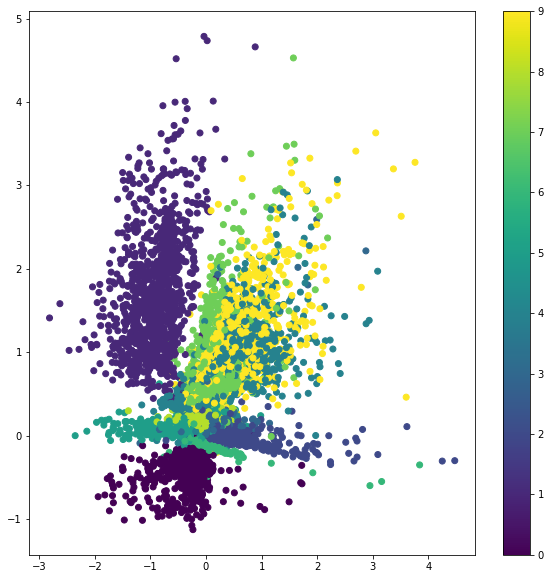

In [8]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10,10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

**Decoder generator**

To make the decoder generator serializable, we will redefine new layers and transfer weights over, rather than sharing the layers. Sharing layers will create new nodes, some with different output shapes, which causes problems for serialization.

Here we also set batch_size to 1

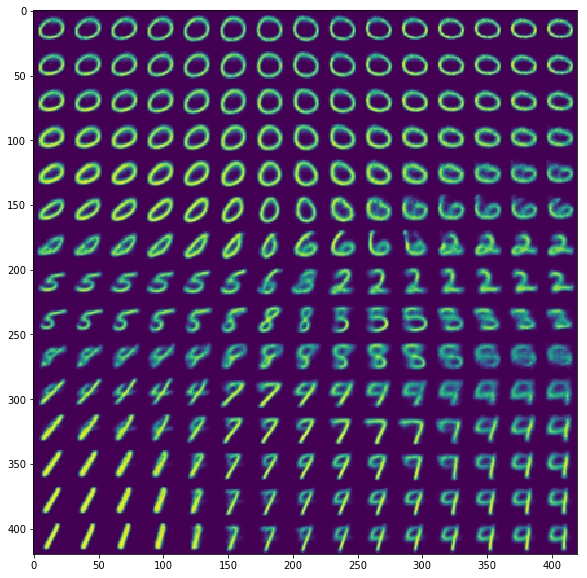

In [13]:
batch_size = 1

_hid_decoded = Dense(intermediate_dim, activation='relu')
_up_decoded = Dense(filters * 14 * 14, activation='relu')
_reshape_decoded = Reshape((14, 14, filters))
_deconv_1_decoded = Conv2DTranspose(filters, kernel_size=num_conv, strides=(1,1),
                                    padding='same', activation='relu')
_deconv_2_decoded = Conv2DTranspose(filters, kernel_size=num_conv, strides=(1,1),
                                    padding='same', activation='relu')
_x_decoded_relu = Conv2DTranspose(filters, kernel_size=(2,2), strides=(2,2),
                                  padding='valid', activation='relu')
_x_decoded_mean_squash = Conv2D(img_chns, kernel_size=(2,2), padding='same', activation='sigmoid')

decoder_input = Input(shape=(latent_dim,))
layer1 = _hid_decoded(decoder_input)
layer2 = _up_decoded(layer1)
layer3 = _reshape_decoded(layer2)
layer4 = _deconv_1_decoded(layer3)
layer5 = _deconv_2_decoded(layer4)
layer6 = _x_decoded_relu(layer5)
layer7 = _x_decoded_mean_squash(layer6)
generator = Model(decoder_input, layer7)

_hid_decoded.set_weights(decoder_hid.get_weights())
_up_decoded.set_weights(decoder_upsample.get_weights())
_deconv_1_decoded.set_weights(decoder_deconv_1.get_weights())
_deconv_2_decoded.set_weights(decoder_deconv_2.get_weights())
_x_decoded_relu.set_weights(decoder_deconv_3_upsamp.get_weights())
_x_decoded_mean_squash.set_weights(decoder_mean_squash.get_weights())

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-1, 1] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10,10))
plt.imshow(figure)
plt.show()

In [14]:
generator.save_weights(WEIGHTS_FILEPATH)

with open(MODEL_ARCH_FILEPATH, 'w') as f:
    f.write(generator.to_json())